# Shape Classifier: Circles, Squares, and Triangles

A Jupyter Notebook to demonstrate the training and evaluation of a CNN model to classify synthetic images of geometric shapes.

**Project Structure Note:** In adherence to the project requirement for `clean, modular, and well-organized code,` complex helper functions for data generation and visualization are encapsulated in the `ShapeClassifier/utils/` directory. This keeps the main notebook focused on the core machine learning workflow: configuration, data loading, model definition, training, and evaluation.

## 1. Setup & Configuration

This section handles all the initial setup for the project:
*   Importing essential libraries.
*   Defining constants, hyperparameters, and file paths.
*   Setting up reproducibility seeds.

### 1.1. Path Configuration

First, we set up the system path to ensure our utility scripts in the `ShapeClassifier/utils/` directory can be imported reliably. We also define the core paths for our project artifacts.

In [85]:
import os
import sys

# We assume this notebook is run from its location in the 'ShapeClassifier' directory.
# The project root is one level up.
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    print(f"Added '{PROJECT_ROOT}' to system path.")

# Define core paths relative to the project root for robustness.
ARTIFACTS_DIR = os.path.join(PROJECT_ROOT, '..', 'shape-classifier-artifacts')
DATASET_DIR = os.path.join(ARTIFACTS_DIR, 'shape-classifier-datasets', 'ShapeClassifier')
MODEL_CHECKPOINT_DIR = os.path.join(ARTIFACTS_DIR, 'shape-classifier-models', 'ShapeClassifier')

print(f"Project Root: {PROJECT_ROOT}")
print(f"Dataset Directory: {DATASET_DIR}")

Project Root: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch
Dataset Directory: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-datasets\ShapeClassifier


### 1.2. Library Imports

Next, we import all the necessary libraries for the project.

In [86]:
import hashlib
import json
import math
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm

print("Libraries imported successfully.")

Libraries imported successfully.


### 1.3. Constants and Seeding

We define key constants for our project and a function to set seeds for reproducibility. The seeding function is called in a separate cell to prevent it from being re-run unnecessarily when constants are changed.

In [87]:
# --- Constants ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLASSES = ['circle', 'square', 'triangle']
NUM_CLASSES = len(CLASSES)
MODEL_CHECKPOINT_PATH = os.path.join(MODEL_CHECKPOINT_DIR, 'best_model_checkpoint.pth')


# --- Seeding Function ---
def set_seed(seed=42):
    """Sets the seed for random, numpy, and torch for reproducible results."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")

print(f"Device set to: {DEVICE.upper()}")

Device set to: CUDA


### 1.4. Initial Setup Execution

Here we execute one-time setup commands: we set the global seed and ensure the directory for saving our model checkpoints exists.

In [88]:
# Set the seed for the entire notebook session.
set_seed(42)

# Ensure the directory for saving model checkpoints exists.
os.makedirs(MODEL_CHECKPOINT_DIR, exist_ok=True)
print("Initial setup executed.")

Seed set to 42
Initial setup executed.


## 2. Data Generation & Loading

This section covers preparing the data for the model. It includes:
*   An optional step to regenerate the entire dataset from scratch.
*   Defining a custom PyTorch `Dataset` class to load the images.
*   Applying necessary transformations.
*   Creating `DataLoader`s to feed data to the model in batches.

### 2.1. Optional: Generate Dataset from Scratch

This project is configured to use the pre-generated (or downloaded) dataset located in the `shape-classifier-artifacts` directory.

However, if you wish to regenerate the entire dataset from scratch, you can set the `REGENERATE_DATA` flag in the cell below to `True`.

**>>> Warning:** This process will delete all existing data in the target directory and will take several minutes to complete.

In [ ]:
from ShapeClassifier.utils.data_generator import generate_dataset

# --- Configuration for Data Generation ---
REGENERATE_DATA = False # Set to True to run the data generation process.

# These parameters are used ONLY if REGENERATE_DATA is True.
TOTAL_IMAGES_TO_GENERATE = 6000
SPLIT_RATIOS = {'train': 0.7, 'validation': 0.15, 'test': 0.15}


if REGENERATE_DATA:
    # We call our imported function using the path constants defined in Section 1.
    generate_dataset(
        root_dir=DATASET_DIR,
        total_images=TOTAL_IMAGES_TO_GENERATE,
        # root_dir=os.path.join(DATASET_DIR, "Delete"),
        # total_images=100,
        splits=SPLIT_RATIOS,
        shapes=CLASSES # Using the 'CLASSES' constant from Section 1
    )
else:
    print("Skipping data generation. Using existing dataset.")

# Verify that the dataset directory exists.
if not os.path.exists(DATASET_DIR):
    print("\nERROR: Dataset directory not found!")
    print(f"Please run the project's download script or set REGENERATE_DATA to True.")
else:
    print(f"\nDataset found at: {DATASET_DIR}")

--- Starting Dataset Generation ---
Clearing existing directory: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-datasets\ShapeClassifier
Creating new directory structure...
------------------------------
Ensuring all split counts are divisible by 12 (shapes * conditions).
--- Adjusted Dataset Split ---
  - Train: 4200 images
  - Validation: 900 images
  - Test: 900 images
Total images to be generated: 6000
------------------------------
Generating 1400 images for train/circle...
Generating 1400 images for train/square...
Generating 1400 images for train/triangle...
Generating 300 images for validation/circle...
Generating 300 images for validation/square...
Generating 300 images for validation/triangle...
Generating 300 images for test/circle...
Generating 300 images for test/square...
Generating 300 images for test/triangle...
--- Dataset Generation Complete ---
Total im

### 2.2. PyTorch Dataset Class

To load our data into PyTorch, we need to create a custom `Dataset` class. This class acts as a standardized interface and is responsible for two key things:
1.  `__len__`: Telling PyTorch the total number of images in the dataset.
2.  `__getitem__`: Providing the i-th item from the dataset, which consists of an image and its corresponding label, ready for the model.

Our `ShapeDataset` class will scan a given directory (e.g., `train`, `validation`, or `test`), find all image paths, and infer the correct label from the subdirectory name (e.g., 'circle', 'square').

In [90]:
class ShapeDataset(Dataset):
    """Custom Dataset for loading shape images."""

    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Directory with all the images, organized in subfolders by class.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.image_paths = []
        self.labels = []

        # Walk through the directory to gather image paths and labels
        for cls_name in self.classes:
            class_dir = os.path.join(data_dir, cls_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.image_paths[idx]
        # Using .convert('L') ensures the image is loaded as single-channel grayscale
        image = Image.open(img_path).convert('L')
        
        # Get the label
        label = self.labels[idx]

        # Apply transformations if they exist
        if self.transform:
            image = self.transform(image)
            
        return image, label

print("ShapeDataset class defined.")

ShapeDataset class defined.


### 2.3. Calculating Normalization Statistics for Z-Score Standardization

A crucial step in preparing image data for a neural network is **normalization**. Normalization rescales the pixel values to a standard range, which helps the model's optimizer converge faster and more reliably. Without it, the large range of pixel values (0-255) can lead to unstable gradients during training.

While a simple approach is to scale values to a fixed range like `[-1, 1]`, a more robust and widely-used technique is **Z-score standardization**. This method transforms the data so that it has a **mean of 0 and a standard deviation of 1**.

The formula for each pixel is:
$$ z = \frac{x - \mu}{\sigma} $$
where:
- $x$ is the original pixel value
- $\mu$ (mu) is the mean of all pixel values in the dataset
- $\sigma$ (sigma) is the standard deviation of all pixel values

To implement this, we must first calculate the true $\mu$ and $\sigma$ from our data.

**>>> Important:** We only ever calculate these statistics on the **training set**. The validation and test sets must remain "unseen." Using statistics from them would be a form of data leakage, giving our model an unfair preview of the data it will be evaluated on.

In the next cell, we create a temporary dataset with a simple `ToTensor()` transform to iterate through all training images and compute these two values.

In [92]:
# Define the path for our cache file within a temp directory
TEMP_DIR = os.path.join(PROJECT_ROOT, 'ShapeClassifier', 'temp')
os.makedirs(TEMP_DIR, exist_ok=True)
STATS_CACHE_PATH = os.path.join(TEMP_DIR, 'dataset_stats.json')

def get_dataset_fingerprint(data_dir):
    """
    Creates a unique fingerprint of a dataset based on its file metadata.
    This is much faster than hashing the file contents.
    """
    file_count = 0
    total_size = 0
    # Use a high-precision sum for modification times
    total_mtime = 0.0

    for root, _, files in os.walk(data_dir):
        for name in files:
            file_count += 1
            file_path = os.path.join(root, name)
            total_size += os.path.getsize(file_path)
            total_mtime += os.path.getmtime(file_path)
            
    # Create a simple but effective string representation of the dataset's state
    fingerprint_str = f"count:{file_count}-size:{total_size}-mtime:{total_mtime}"
    return hashlib.sha256(fingerprint_str.encode('utf-8')).hexdigest()

def calculate_or_load_stats(data_dir, cache_path):
    """Loads stats from cache if the dataset fingerprint matches, otherwise computes and saves them."""
    print("--- Checking dataset for normalization stats ---")
    current_fingerprint = get_dataset_fingerprint(data_dir)
    
    # Try to load from cache
    if os.path.exists(cache_path):
        with open(cache_path, 'r') as f:
            cached_data = json.load(f)
        if cached_data.get('fingerprint') == current_fingerprint:
            print("Dataset fingerprint matches cache. \nLoading normalization stats.")
            mean = torch.tensor(cached_data['mean'])
            std = torch.tensor(cached_data['std'])
            return mean, std

    print("Cache not found or dataset has changed. \nRe-calculating normalization stats...")
    
    # --- The calculation logic ---

    # Create a temporary dataset of the training data just for calculating the mean and std
    # We only need to convert images to tensors for this calculation.
    temp_dataset = ShapeDataset(data_dir, transform=transforms.ToTensor())

    # Use a DataLoader to iterate through the dataset efficiently.
    # Note: `num_workers` is not set. In a Jupyter/IPython environment, especially on
    # Windows, using multiple workers for data loading can lead to multiprocessing
    # deadlocks. By leaving it at its default (0), data loading occurs in the
    # main process, ensuring compatibility.
    temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False)

    # Calculate mean and std
    mean = 0.
    std = 0.
    num_samples = 0

    print("Calculating mean and standard deviation from the training set...")
    # Wrap the loader with tqdm for a progress bar
    for images, _ in tqdm(temp_loader, desc="Calculating Stats"):
        # Reshape images to (batch_size, num_pixels) and count samples
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        # Update mean and std
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        num_samples += batch_samples

    mean /= num_samples
    std /= num_samples

    # --- Save the new stats to the cache with the new fingerprint ---
    new_cache_data = {'mean': mean.tolist(), 'std': std.tolist(), 'fingerprint': current_fingerprint}
    with open(cache_path, 'w') as f:
        json.dump(new_cache_data, f, indent=4)
    print("New stats calculated and saved to cache.")
    
    del temp_loader, temp_dataset # Clean up
    print("Temporary objects for calculation have been cleaned up.")
    return mean, std

# --- Execute the function ---
train_dir = os.path.join(DATASET_DIR, 'train')
mean, std = calculate_or_load_stats(train_dir, STATS_CACHE_PATH)

print(f"\nUsing Mean: {mean.item():.8f}")
print(f"Using Std: {std.item():.8f}")

del TEMP_DIR, STATS_CACHE_PATH, train_dir
print("\nTemporary objects for calculation have been cleaned up.")

--- Checking dataset for normalization stats ---
Dataset fingerprint matches cache. 
Loading normalization stats.

Using Mean: 0.50911647
Using Std: 0.24480122

Temporary objects for calculation have been cleaned up.


### 2.4. Defining the Final Image Transformation Pipelines

Now that we have the exact mean and standard deviation of our training data, we can build our final transformation pipelines. We use `torchvision.transforms.Compose` to chain together multiple operations.

Our pipeline will consist of two steps:
1.  `transforms.ToTensor()`: This is a critical first step. It converts the PIL Image, which is a grid of pixels with values from `[0, 255]`, into a PyTorch FloatTensor. It also automatically scales the pixel values to a range of `[0.0, 1.0]`.
2.  `transforms.Normalize(mean, std)`: This takes the `[0.0, 1.0]` tensor from the previous step and applies the Z-score formula ($z = (x - \mu) / \sigma$), using the `mean` and `std` we just calculated.

We create two separate pipelines. Although they are identical in this case, it is good practice to distinguish between them. In more complex projects, the training pipeline might include additional data augmentation steps (like random rotations or flips) that should not be applied to the validation or test data.

In [8]:
# Define the final transformations for our datasets using the calculated stats.
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val_test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

print("Data transformations defined with calculated mean and std.")

Data transformations defined with calculated mean and std.


### 2.5. Create Final Datasets and DataLoaders

With our `ShapeDataset` class defined and our `data_transforms` ready, we can now create the final dataset instances for our training, validation, and test splits.

These `Dataset` objects are then wrapped by a `DataLoader`. The `DataLoader` is a powerful PyTorch utility that handles:
-   **Batching:** Grouping individual data points into mini-batches of a specified size.
-   **Shuffling:** Randomly shuffling the training data at the beginning of each epoch to prevent the model from learning the order of the data.
-   **Parallel Loading:** (Which we have disabled for notebook compatibility) Loading data in the background.

In [9]:
# --- Hyperparameters for DataLoaders ---
# We define BATCH_SIZE here to keep all hyperparameters in one place,
# but it's used in this section.
BATCH_SIZE = 32

# Create Dataset instances for each split, applying the correct transforms
image_datasets = {
    'train': ShapeDataset(os.path.join(DATASET_DIR, 'train'), transform=data_transforms['train']),
    'validation': ShapeDataset(os.path.join(DATASET_DIR, 'validation'), transform=data_transforms['val_test']),
    'test': ShapeDataset(os.path.join(DATASET_DIR, 'test'), transform=data_transforms['val_test'])
}

# Create DataLoader instances for each split
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True),
    'validation': DataLoader(image_datasets['validation'], batch_size=BATCH_SIZE, shuffle=False),
    'test': DataLoader(image_datasets['test'], batch_size=BATCH_SIZE, shuffle=False)
}

# Store dataset sizes for later use
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

Dataset sizes: {'train': 4200, 'validation': 900, 'test': 900}
Class names: ['circle', 'square', 'triangle']


### 2.6. Visualize a Batch of Training Data

As a final sanity check, let's visualize a few images from a single training batch. This helps us confirm that:
-   The images are being loaded correctly.
-   The labels are accurate.
-   The normalization has been applied (note that the colors may look unusual because the pixel values have been shifted and scaled).

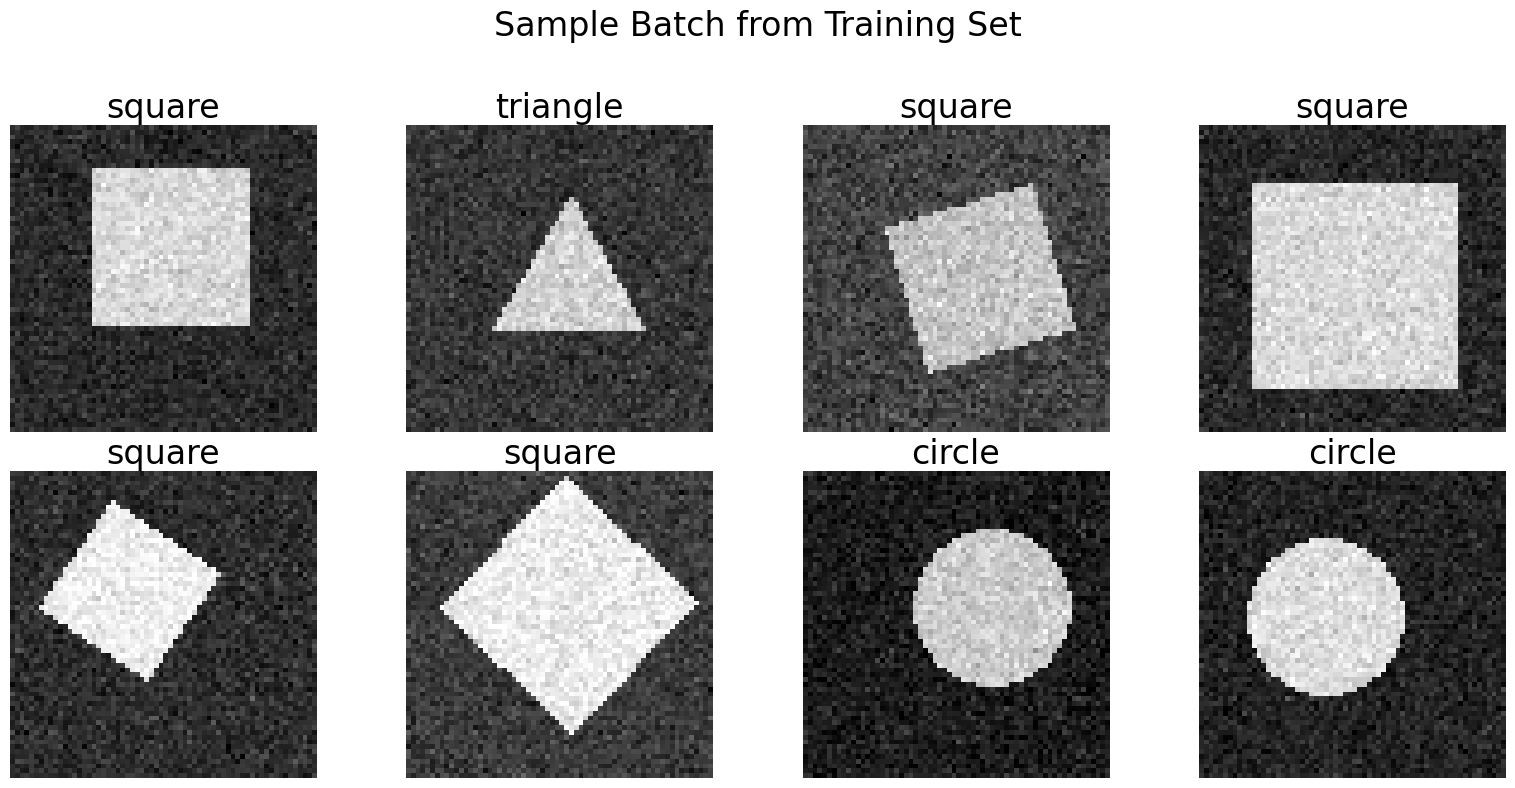

Visualization variables cleared.


In [53]:
def visualize_batch(dataloader, class_names, mean, std, num_images_to_show=8, cols=4):
    """
    Visualizes a batch of images from a dataloader with a flexible grid.
    
    Args:
        dataloader (DataLoader): The dataloader for the training set.
        class_names (list): A list of strings for class names.
        mean (torch.Tensor): The mean used for normalization.
        std (torch.Tensor): The standard deviation used for normalization.
        num_images_to_show (int): The total number of images to display.
        cols (int): The number of columns in the display grid.
    """
    
    # Get one batch of training data
    inputs, classes_idx = next(iter(dataloader))
    
    # Move inputs to CPU for processing with numpy/matplotlib
    inputs = inputs.cpu()
    
    # --- 1. DYNAMIC GRID CALCULATION ---
    # Ensure we don't try to show more images than are in the batch
    num_images_to_show = min(num_images_to_show, len(inputs))
    
    # Calculate the number of rows needed
    rows = math.ceil(num_images_to_show / cols)
    
    # Define figure size dynamically
    figsize = (cols * 4, rows * 4)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle("Sample Batch from Training Set", fontsize=24)

    # Flatten axes array for easy iteration, regardless of grid shape
    axes = axes.flatten()

    # De-normalize and plot each image
    for i in range(num_images_to_show):
        ax = axes[i]
        
        inp = inputs[i].numpy().transpose((1, 2, 0))
        mean_np = np.array([mean.item()])
        std_np = np.array([std.item()])
        inp = std_np * inp + mean_np
        inp = np.clip(inp, 0, 1)
        
        ax.imshow(inp, cmap='gray')
        ax.set_title(class_names[classes_idx[i]], fontsize=24)
        ax.axis('off') # Hide axes ticks

    # If there are any empty subplots left, turn them off
    for i in range(num_images_to_show, len(axes)):
        axes[i].axis('off')

    # --- 2. FIX SPACING ISSUE ---
    # Use fig.tight_layout() with a rect parameter to make space for the suptitle.
    # rect=[left, bottom, right, top] in normalized figure coordinates.
    # The 'top=0.95' leaves 5% of the figure height for the suptitle.
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    
    plt.show()
    
    # --- Clean up to free memory ---
    del inputs
    del classes_idx
    print("Visualization variables cleared.")

visualize_batch(dataloaders['train'], class_names, mean, std, num_images_to_show=8, cols=4)

## 3. Model Architecture

Here, we define the architecture of our neural network. For this image classification task, a **Convolutional Neural Network (CNN)** is the ideal choice.

### Why a CNN?

CNNs are the industry standard for computer vision tasks for several key reasons:

1.  **Spatial Hierarchy of Features:** Unlike a simple fully-connected network that treats an image as a flat vector of pixels, a CNN processes it as a 2D grid. Its core components, convolutional layers, are designed to learn a hierarchy of features.
    -   **Early layers** automatically learn to detect simple patterns like edges, corners, and gradients.
    -   **Deeper layers** combine these simple patterns to recognize more complex features, such as the curve of a circle or the right-angle corners of a square.

2.  **Parameter Sharing:** A single convolutional filter (e.g., an edge detector) is slid across the entire image. This means the model learns one set of weights for that filter and re-uses it everywhere. This is incredibly efficient compared to a fully-connected layer, which would need a separate weight for every single pixel, leading to an explosion in parameters.

3.  **Translation Invariance:** Because the same filter is applied across the whole image, a CNN can detect a feature (like a triangle corner) regardless of where it appears in the image. This is a direct result of parameter sharing and is crucial for our task, as our shapes are randomly placed.

For this problem, a relatively simple CNN with a few convolutional layers followed by a classifier head is sufficient. It is powerful enough to learn the distinguishing features of our shapes without being so complex that it overfits our synthetic dataset. We do not need a large, pre-trained model like ResNet or a Vision Transformer, as that would be overkill for this task.

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        # --- Convolutional Layers ---
        # Our input is a 64x64 grayscale image (1 channel).
        self.features = nn.Sequential(
            # Layer 1
            # Input: 1 x 64 x 64
            # Output: 16 x 32 x 32
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 2
            # Input: 16 x 32 x 32
            # Output: 32 x 16 x 16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 3
            # Input: 32 x 16 x 16
            # Output: 64 x 8 x 8
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # --- Classifier (Fully Connected Layers) ---
        # After 3 max-pooling layers of stride 2, our 64x64 image is now 8x8.
        # So the flattened feature map size is 64 channels * 8 * 8 = 4096.
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5), # Dropout for regularization
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        # Flatten the feature map to a vector before feeding it to the classifier
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x

# Instantiate the model and move it to the configured device (CPU or GPU)
model = SimpleCNN(num_classes=NUM_CLASSES).to(DEVICE)

# Print the model architecture
print(model)

# A quick test to see the output shape of a sample batch
def test_model_output():
    with torch.no_grad():
        sample_batch, _ = next(iter(dataloaders['train']))
        sample_batch = sample_batch.to(DEVICE)
        output = model(sample_batch)
        print("\n--- Model Test ---")
        print(f"Input batch shape: {sample_batch.shape}")
        print(f"Output batch shape: {output.shape}")
        print("Model test passed. Output shape is correct.")

test_model_output()

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=3, bias=True)
  )
)

--- Model Test ---
Input batch shape: torch.Size([32, 1, 64, 64])
Output batch shape: torch.Size([32, 3])
Model test passed. Output shape is correct.


## 4. Training the Model

This section contains the logic for training the model, including:
*   Defining the loss function and optimizer.
*   Implementing the training and validation loops.
*   Incorporating early stopping and model checkpointing to save the best-performing model.

## 5. Evaluation

After training, we evaluate the model's performance on the unseen test set. This includes:
*   Loading the best model checkpoint.
*   Calculating final test accuracy.
*   Visualizing a confusion matrix and sample predictions.

## 6. Analysis & Conclusion

A final summary of the results, including:
*   Plotting the training/validation curves.
*   Answering the project questions on learnings and potential improvements.